In [51]:
import numpy as np
from models_gaussian import GaussianDenseHMM, HMMLoggingMonitor
import time

import wandb
from utils import dtv, permute_embeddings, compute_stationary,  empirical_coocs
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erf
from sklearn.cluster import KMeans

from celluloid import Camera
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [52]:
np.random.seed(2022)

simple_model = {"mu": 10,
                "sigma": 1}

complicated_model = {"mu": 5,
                     "sigma": 2}

data_sizes = [(100, 400, 4)]  # (s, T, n) TODO:  fill

ls = (2, 3, 4,  5)
ms = (4, 8, 12, 64, 128)

In [53]:
def prepare_params(n, simple_model=True):
    A = np.exp(np.random.uniform(0, 5, size=(n, n)))
    A /= A.sum(axis=1)[:, np.newaxis]

    pi = compute_stationary(A)

    if simple_model:
        mu = np.arange(n) * 10
        sigma = np.ones(shape=n)
    else:
        mu = np.random.uniform(0, n * 3, size=n)
        sigma = np.random.uniform(.5, 1.75, size=n)
    return pi, A, mu, sigma


def my_hmm_sampler(pi, A, mu, sigma, T):
    n = pi.shape[0]
    X = [np.random.choice(np.arange(n), 1, replace=True, p=pi)]
    for t in range(T - 1):
        X.append(np.random.choice(np.arange(n), 1, replace=True, p=A[X[t][0], :]))
    Y = np.concatenate([np.random.normal(mu[s[0]], sigma[s[0]], 1) for s in X]).reshape(-1, 1)
    return X, Y


def init_experiment(dsize, simple_model):
    s = dsize[0]
    T = dsize[1]
    n = dsize[2]
    pi, A, mu, sigma = prepare_params(n, simple_model)

    data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
    X_true = np.concatenate([np.concatenate(y[0]) for y in data])  # states
    Y_true = np.concatenate([x[1] for x in data])  # observations
    lengths = [len(x[1]) for x in data]

    return s, T, n, pi, A, mu, sigma, X_true, Y_true, lengths

In [54]:
def to_discrete_q(X, m):
    nodes = np.concatenate([np.quantile(X, [i / m for i in range(1, m)]), np.array([np.infty])])
    return (X > nodes.reshape(1, -1)).sum(axis=-1).reshape(-1, 1), nodes.reshape(-1)

def to_discrete(X, m):
    kmeans = KMeans(n_clusters=m, random_state=0).fit(Y_true)
    nodes_tmp = np.sort(kmeans.cluster_centers_, axis=0)
    nodes = np.concatenate([(nodes_tmp[1:] + nodes_tmp[:-1]) / 2, np.array([[np.infty]])])
    return (X > nodes.reshape(1, -1)).sum(axis=-1).reshape(-1, 1), nodes.reshape(-1)

def empirical_cooc_prob(Xd, m, lengths):
    freqs, gt_omega_emp = empirical_coocs(Xd, m, lengths=lengths)
    return np.reshape(gt_omega_emp, newshape=(m, m))

def normal_cooc_prob(means, covars, Qs, A):
    A_stationary = compute_stationary(A, False)
    B_scalars_tmp = .5 * (1 + erf((Qs[:-1, np.newaxis] - np.transpose(means)) / np.transpose(covars) / np.sqrt(2)))
    B_scalars_tmp = np.concatenate([np.zeros((1, B_scalars_tmp.shape[1])), B_scalars_tmp, np.ones((1, B_scalars_tmp.shape[1]))], axis=0)
    B_scalars = np.transpose(B_scalars_tmp[1:, :] - B_scalars_tmp[:-1, :])
    theta = A * A_stationary[:, None]
    return np.matmul(np.transpose(B_scalars), np.matmul(theta, B_scalars))

In [55]:
def visualize_distribution(mu, sigma, n, simple_model):
    x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3 * max(sigma), 10000)
    for i in range(n):
        plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i))
    plt.title(f"Normal PDFs n={n}-s={s}-T={T}-simple={simple_model}")
    plt.show()

def visualize_matrix(mat, title="", vmax=1):
    sns.heatmap(mat, cmap="hot", vmax=vmax)
    plt.title(title)
    plt.show()

In [56]:
M=10
EM_ITER = 20
l = 8
ITER = 100000
TOLERANCE = 1e-4

def em_scheduler(max_lr, it):
    if it <= np.ceil(ITER / 3):
        return max_lr * np.cos(3 * (np.ceil(ITER / 3) - it) * np.pi * .33 / ITER)
    else:
        return max_lr * np.cos((it - np.ceil(ITER / 3)) * np.pi * .66 / ITER)  ** 2

mstep_cofig = {"cooc_lr": 0.1, "cooc_epochs": ITER, "l_uz": 10,
               "em_lr":  0.01, "em_epochs":20, 'loss_type': 'square', "scheduler": em_scheduler}
s, T, n, pi, A, mu, sigma, X_true, Y_true, lengths = init_experiment(dsize=(100, 100, 10), simple_model=True)

In [57]:
t = time.localtime()

true_values = {
    "states": X_true,
    "transmat": A,
    "startprob": pi,
    "means": mu,
    "covars": sigma
}

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"benchmark-{t.tm_year}-{t.tm_mon}-{t.tm_mday}-debug3",
        "job_type": f"n={n}-s={s}-T={T}-simple={simple_model}",
        "name": f"PDFs",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": s,
        "T": T,
        "model": None,
        "m": None,
        "l": None,
        "lr":  0,
        "em_epochs":  0,
        "em_iter": EM_ITER,
        "cooc_epochs": ITER,
        "epochs": 0,
        "simple_model": simple_model
    }
}

wandb.init(**wandb_params["init"], config=wandb_params["config"])

wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
                             "name": f"dense--l={l}-lr={mstep_cofig['cooc_lr']}-epochs={mstep_cofig['cooc_epochs']}-{time.asctime()}"})
wandb_params["config"].update(dict(model="dense_cooc_em_penalty", m=n, l=l, lr=mstep_cofig['cooc_lr'], em_epochs=10,
                                   em_iter=EM_ITER, cooc_epochs=mstep_cofig['cooc_epochs'], epochs=mstep_cofig['cooc_epochs'],
                                   loss_type='square', scheduler=True))

wandb.init(**wandb_params["init"], config=wandb_params["config"])


accuracy,███████████████████████████████████████▁
covars_mae,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█
means_mae,▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃█
omage_dtv,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
time,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅█
total_log_prob,▅▆▇▇▇▇▇████████████████████████████████▁
transmat_dtv,▆▄▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█
accuracy,0.3676
covars_mae,35.45841
means_mae,6.03585


In [58]:
Y_disc, nodes = to_discrete(Y_true, m=n)

In [59]:
nodes

array([ 5.01796503, 15.04382063, 25.07544038, 35.06153989, 44.96899836,
       54.97948219, 64.98741535, 74.97333303, 84.98663314,         inf])

array([ 5.01796503, 15.04382063, 25.07544038, 35.06153989, 44.96899836,
       54.97948219, 64.98741535, 74.97333303, 84.98663314,         inf])

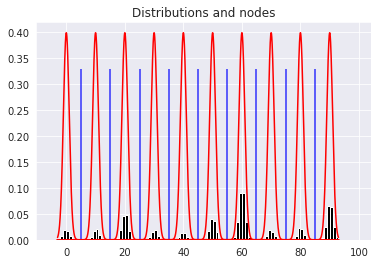

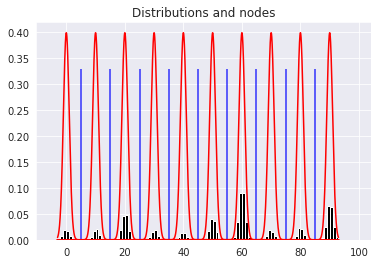

In [60]:
# Y_disc, nodes = to_discrete_q(Y_true, m=4)

plt.vlines(nodes, np.zeros(nodes.shape), np.ones(nodes.shape) * 0.33, color="blue", alpha = 0.8)
plt.hist(Y_true, bins=[i for i in range(-5,  n * 10)], color="black", density=True)
x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma), 10000)
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i), color="red")
plt.title("Distributions and nodes")
plt.show()

In [61]:
omega_emp = empirical_cooc_prob(Y_disc, n, lengths)

In [62]:
omega_gt = normal_cooc_prob(mu, sigma, nodes, A)

In [63]:
# omega_emp = np.exp(omega_emp)
# omega_gt = np.exp(omega_gt)

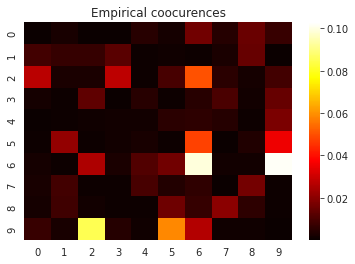

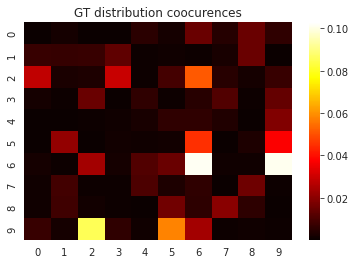

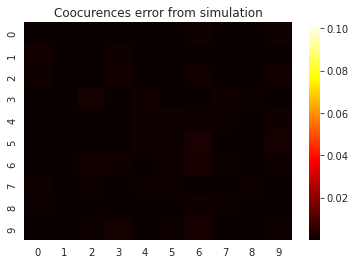

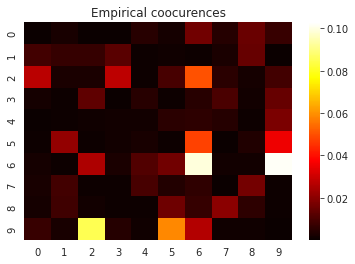

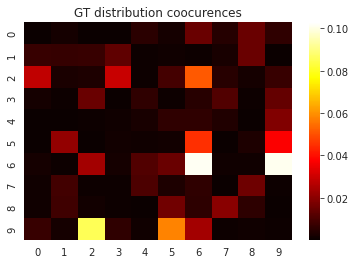

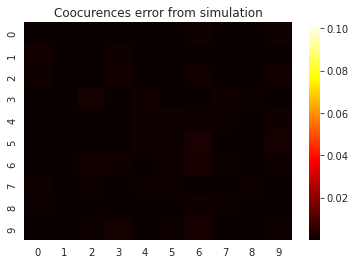

In [64]:
vmax = max(omega_emp.max(), omega_gt.max(), (omega_emp - omega_gt).max()) +1e-3
visualize_matrix(omega_emp, title="Empirical coocurences", vmax=vmax)
visualize_matrix(omega_gt, title="GT distribution coocurences",  vmax=vmax)
visualize_matrix(abs(omega_gt - omega_emp), title="Coocurences error from simulation", vmax=vmax)

In [65]:
nodes

array([ 5.01796503, 15.04382063, 25.07544038, 35.06153989, 44.96899836,
       54.97948219, 64.98741535, 74.97333303, 84.98663314,         inf])

array([ 5.01796503, 15.04382063, 25.07544038, 35.06153989, 44.96899836,
       54.97948219, 64.98741535, 74.97333303, 84.98663314,         inf])

In [42]:
for  _  in range(1):  # TODO: can be run multiple times for comparison
    mstep_cofig = {"cooc_lr": 0.3, "cooc_epochs": ITER, "l_uz": 10,
               "em_lr":  0.01, "em_epochs":20, 'loss_type': 'square', "scheduler": em_scheduler}
    wandb_params["init"].update({"name": f"dense--l={l}-lr={mstep_cofig['cooc_lr']}-epochs={mstep_cofig['cooc_epochs']}-{time.asctime()}"})
    hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                    wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                    log_config={'metrics_after_convergence': True})
    densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                                covariance_type='diag', opt_schemes={"cooc", "em"},
                                nodes=np.concatenate([np.array([-np.infty]), nodes]),
                                discrete_observables=n, em_iter=20,
                                logging_monitor=hmm_monitor,
                                init_params="", params="stmc", early_stopping=True)
    densehmm.means_ = mu.reshape(-1, 1)
    start = time.perf_counter()
    densehmm.fit_coocs(Y_true, lengths)
    # densehmm.fit(Y_true, lengths)
    time_tmp = time.perf_counter() - start

         1      -64306.9538             +nan
         2      -52876.1655      +11430.7883
         3      -48398.1626       +4478.0029
         4      -45380.4930       +3017.6696
         5      -44834.3389        +546.1541
         6      -44375.6991        +458.6398
         7      -43949.3275        +426.3716
         8      -43515.8563        +433.4712
         9      -43044.3347        +471.5216
        10      -42517.2879        +527.0468
        11      -42030.5321        +486.7558
        12      -41672.8248        +357.7073
        13      -41360.7626        +312.0622
        14      -41069.9739        +290.7887
        15      -40784.6150        +285.3589
        16      -40474.5732        +310.0418
        17      -40151.3951        +323.1780
        18      -39931.5098        +219.8853
        19      -39747.5724        +183.9374
        20      -39569.3955        +178.1769
        21      -39393.2098        +176.1857
        22      -39218.2585        +174.9513
        23

         1      -86462.1319             +nan
         2      -80538.2854       +5923.8465
         3      -78009.7553       +2528.5302
         4      -73880.1135       +4129.6417
         5      -70014.8561       +3865.2574
         6      -67893.4196       +2121.4366
         7      -65109.5232       +2783.8964
         8      -63682.7460       +1426.7772
         9      -62469.6999       +1213.0461
        10      -61207.3431       +1262.3567
        11      -59241.5590       +1965.7841
        12      -58272.8375        +968.7216
        13      -58056.7280        +216.1095
        14      -57819.4864        +237.2415
        15      -57562.3597        +257.1267
        16      -57299.3496        +263.0101
        17      -57055.3960        +243.9536
        18      -56839.1140        +216.2820
        19      -56651.7006        +187.4134
        20      -56520.6016        +131.0990
        21      -56461.1798         +59.4218
        22      -56454.0831          +7.0967
        23

In [43]:
pca_z = PCA(n_components=2).fit(hmm_monitor.z[-1])
z = [pca_z.transform(x) for x in hmm_monitor.z]

z0 = hmm_monitor.z0

pca_u = PCA(n_components=2).fit(np.transpose(hmm_monitor.u[-1]))
u = [pca_u.transform(np.transpose(x)) for x in hmm_monitor.u]

def draw_embeddings(z, name="?"):
    fig = plt.figure(figsize=(5,5))
    camera = Camera(fig)
    cmap = cm.rainbow(np.linspace(0, 1, len(z[0])))
    for z_el in z:
        if z_el.shape[1] > 1:
            plt.scatter(z_el[:, 0],  z_el[:, 1], color=cmap)
        else:
            plt.scatter(np.arange(z_el.shape[0]), z_el, color=cmap)
        camera.snap()
    plt.title(f"Embaddings trajectory:  {name}")
    animation = camera.animate()
    wandb.log({f"Embaddings trajectory:  {name}": wandb.Html(animation.to_html5_video())})
    plt.close()

draw_embeddings(z, "z")
draw_embeddings(z0, "z0")
draw_embeddings(u, "u")

In [44]:
feed_dict = {densehmm.omega_gt_ph: omega_emp}
feed_dict[densehmm.A_stationary] = compute_stationary(densehmm.session.run(densehmm.A_from_reps_hmmlearn), verbose=False)
feed_dict[densehmm.lr_cooc_placeholder] = 0.1
omega_learned = densehmm.session.run(densehmm.omega, feed_dict)

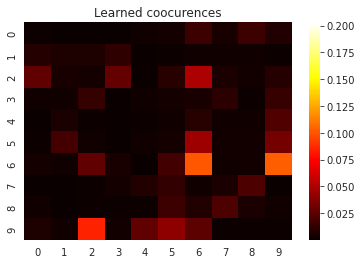

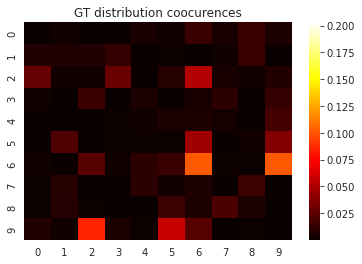

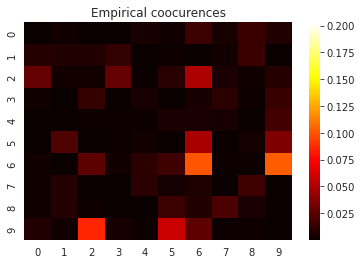

In [45]:
vmax = max(omega_learned.max(), omega_gt.max(), (omega_learned - omega_gt).max()) +  1e-1
visualize_matrix(omega_learned, title="Learned coocurences", vmax=vmax)
visualize_matrix(omega_gt, title="GT distribution coocurences",  vmax=vmax)
visualize_matrix(omega_emp, title="Empirical coocurences", vmax=vmax)

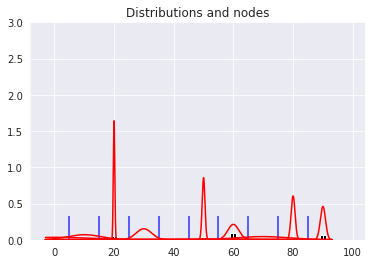

In [46]:
plt.vlines(nodes, np.zeros(nodes.shape), np.ones(nodes.shape) * 0.33, color="blue", alpha = 0.8)
plt.hist(Y_true, bins=[i for i in range(100)], color="black", density=True)
x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma), 10000).reshape(-1)
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, densehmm.means_[i], densehmm.covars_[i, 0]).reshape(-1), label=str(i), color="red")
plt.title("Distributions and nodes")
plt.ylim(0, 3)
plt.show()

In [47]:
densehmm.fit(Y_true, lengths)

# TODO: FIX THE BUG!!!

Fit model:   0%|                                         | 0/20 [00:00<?, ?it/s]/ziob/klaudia/recommender_system/src/models/gaussian_dense_hmm/dense-hmm/code_dense_hmm/models_gaussian.py:1084: RuntimeWarning: divide by zero encountered in log
  log_B = np.log(np.array([[[multivariate_normal.pdf(X[j, i], m, c) for m, c in zip(self.means_, self._covars_)] for i in range(X.shape[1])] for j in range(X.shape[0])]))
/ziob/klaudia/recommender_system/src/models/gaussian_dense_hmm/dense-hmm/code_dense_hmm/models_gaussian.py:1084: RuntimeWarning: divide by zero encountered in log
  log_B = np.log(np.array([[[multivariate_normal.pdf(X[j, i], m, c) for m, c in zip(self.means_, self._covars_)] for i in range(X.shape[1])] for j in range(X.shape[0])]))
/ziob/klaudia/recommender_system/src/models/gaussian_dense_hmm/dense-hmm/code_dense_hmm/models_gaussian.py:1084: RuntimeWarning: divide by zero encountered in log
  log_B = np.log(np.array([[[multivariate_normal.pdf(X[j, i], m, c) for m, c in zip(self.

Exiting EM early ... (convergence tol)


/ziob/klaudia/recommender_system/src/models/gaussian_dense_hmm/dense-hmm/code_dense_hmm/models_gaussian.py:1084: RuntimeWarning: divide by zero encountered in log
  log_B = np.log(np.array([[[multivariate_normal.pdf(X[j, i], m, c) for m, c in zip(self.means_, self._covars_)] for i in range(X.shape[1])] for j in range(X.shape[0])]))
/ziob/klaudia/recommender_system/src/models/gaussian_dense_hmm/dense-hmm/code_dense_hmm/models_gaussian.py:1085: RuntimeWarning: divide by zero encountered in log
  log_pi = np.log(self.startprob_)


AttributeError: 'GaussianDenseHMM' object has no attribute 'nodes'

AttributeError: 'GaussianDenseHMM' object has no attribute 'nodes'

AttributeError: 'GaussianDenseHMM' object has no attribute 'nodes'

In [48]:
densehmm.means_

array([[ 2.21679002],
       [10.12692225],
       [19.96223233],
       [30.14381876],
       [53.77028465],
       [49.91926645],
       [59.99420625],
       [80.39932738],
       [78.92907683],
       [90.0583406 ]])

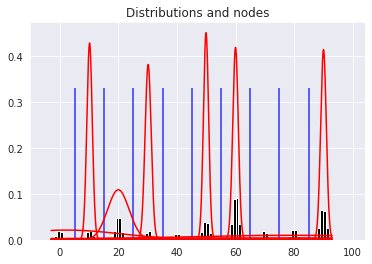

In [49]:
plt.vlines(nodes, np.zeros(nodes.shape), np.ones(nodes.shape) * 0.33, color="blue", alpha = 0.8)
plt.hist(Y_true, bins=[i for i in range(-5,  n * 10)], color="black", density=True)
x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma), 10000).reshape(-1)
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, densehmm.means_[i], densehmm.covars_[i, 0]).reshape(-1), label=str(i), color="red")
plt.title("Distributions and nodes")
plt.show()

In [50]:
densehmm.score(Y_true, lengths)

-73231.85334864377